 Micrograd is basically an autograd (automatic gradient) engine. Where it implements backpropogation. Iteratively tune the weights of a model.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Defining a function which takes x as the input and gives y as the output

In [2]:
def f(x):
    return 3*x**2 - 4*x +5

In [3]:
# Running the function
f(10.0)

265.0

Creating a set of input values that we can feed in to the function that we just created

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys # Applies the function on all these values independently

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

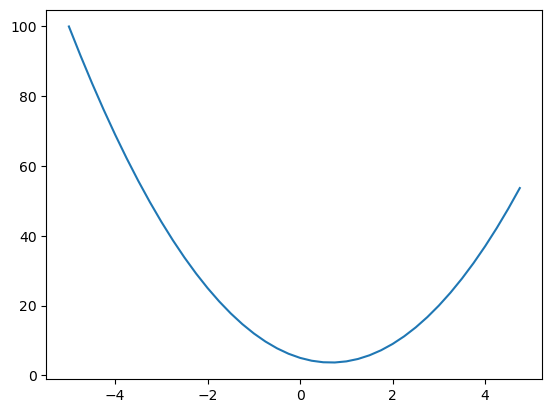

In [6]:
plt.plot(xs, ys)

To calculate the derrivative of the og function we will have to create a chain rule expression. We will not be doing that instead we will just follow the definition of derivative. That is the

$L = lim_{h->0}\frac{f(a + h) - f(a)}{h}$

Which is the slope of that function at that point

In [7]:
# We will use this function

h = 0.000000000000001 # Smallest value as the variable h is stored 
                      # in float and can be truncated to 0
a = 1/3
(f(a + h) - f(a)) / h

-1.7763568394002502

In [8]:
a = 2/3 # Slope = 0
(f(a + h) - f(a)) / h

0.0

Here, it means that when we nudge the point in any direction there is no change in the function's response.

In [9]:
# Choosing a better function
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
# Let's calculate it's derivative too

h = 0.000000001

#input
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("D1", d1)
print("D2", d2)
print('Slope', (d2-d1)/h)

D1 4.0
D2 3.9999999969999998
Slope -3.000000248221113


We can check if the slope is valid or not by looking at the expression above. As the slope w.r.t. 'a' will be 'b'. Which is -3

In [122]:
# We would want to get the derivatives of NNs which are pretty massive
# Therefore we would want a datastructure that can be useful when working with NNs

class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda:None  # for default (a leaf node) a function that doesn't do anything
        self._prev = set(_children) # For efficiency we did it like this
        self._op = _op # For maintaining the operation that created the children
        self.label = label
        
    def __repr__(self): # Providing us a way to print out a nicer expression in python
        return f"Value(data={self.data})"
    
    def __radd__(self, other):
        return self + other
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # We added (self, other) as those are the children of this node
        
        def _backward():
            self.grad += 1.0 * out.grad # The local derrivative of self is 1.0
            other.grad += 1.0 * out.grad 
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        
        return out
    
    def __rmul__(self, other): #other *self
        return self*other
    
    def __pow__(self, other): # self**k
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad  # Here power (**) takes precedence over other operation in python
            
        out._backward = _backward
        
        return out
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return self - other
    
    def tanh(self): # we don;t need to implement the formula for tanh as it is not necessary all we need to know is
                    # how to calculate the local derrivative of this node
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out = Value(t, (self,), 'tanh')
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
e = a*b; e.label='e'

Here, python is internally using the wrapper function to return this string. That we saw above

In [12]:
c = Value(5.0, label='c')
a*c

Value(data=10.0)

In [13]:
d = e + c; d.label='d'
#d = (a.__mul__(c)).__add__(b) # We can call this manually as well
print(d)

Value(data=-1.0)


We added the pointers to keep the connections between the graphs for keeping a record of what values produce the other values.

In [14]:
d._prev

{Value(data=-6.0), Value(data=5.0)}

In [15]:
d._op

'+'

As we can observe now that these representation can be a bit complex to show therefore we need a better way of representing the graph. The code block below allows us to show the graph visually

In [16]:
from graphviz import Digraph

def trace(root):
    # Build a set of all the nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name = uid, label = "{ %s | data %.4f| grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

Here, the only value objects are shown in rectangles. While the op nodes are shown to explain the graph more nicely.

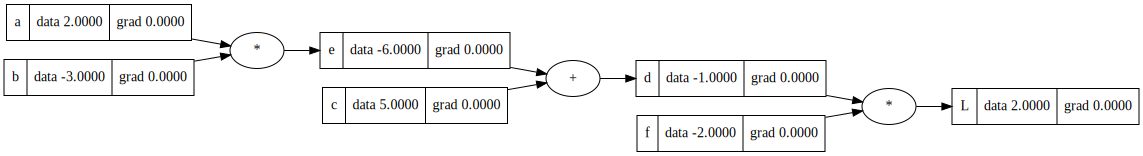

In [61]:
f = Value(-2.0, label='f')
L = d * f; L.label='L'
draw_dot(L)

We have made a forward pass here and created a nice visualization for the same. Now we will try to do backpropagation on these operations. Also, a plus is just a distributer of gradient

In [62]:
# Now not to pollute the variables above we will create a function such 
# That the variables are stored locally

def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label= 'f')
    L = f * d; L.label='L'
    L1 = L.data
    
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label= 'f')
    L = f * d; L.label='L'
    L2 = L.data
    
    return(L2 - L1)/h # Rise over run normalized by h
    
print('derrivative of L by a', lol())

derrivative of L by a 6.000000000021544


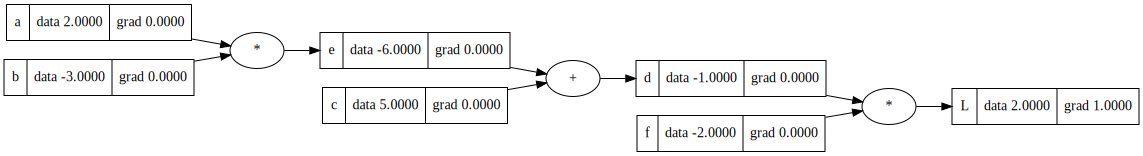

In [63]:
# For L
def loL():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label= 'f')
    L = f * d; L.label='L'
    L1 = L.data
    
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label= 'f')
    L = f * d; L.label='L'
    L2 = L.data + h
    
    return(L2 - L1)/h # Rise over run normalized by h
L.grad = loL()
draw_dot(L)

Creating a neuron and applying backprop on it

In [64]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.7, label='b')
# The expression was made in small steps such that we have poiters to them
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

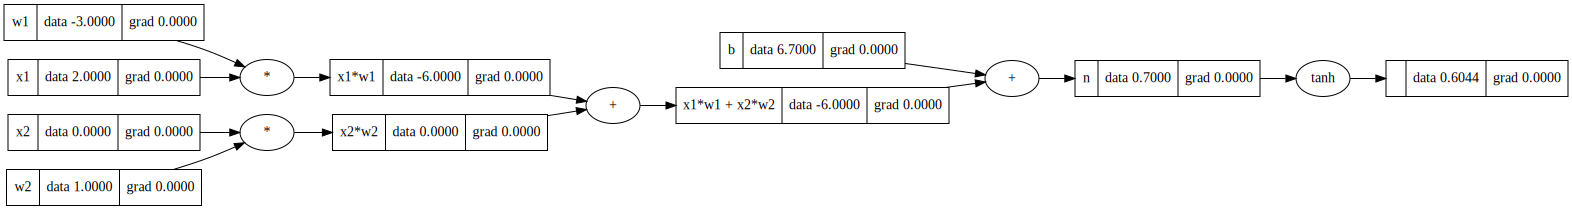

In [65]:
draw_dot(o)

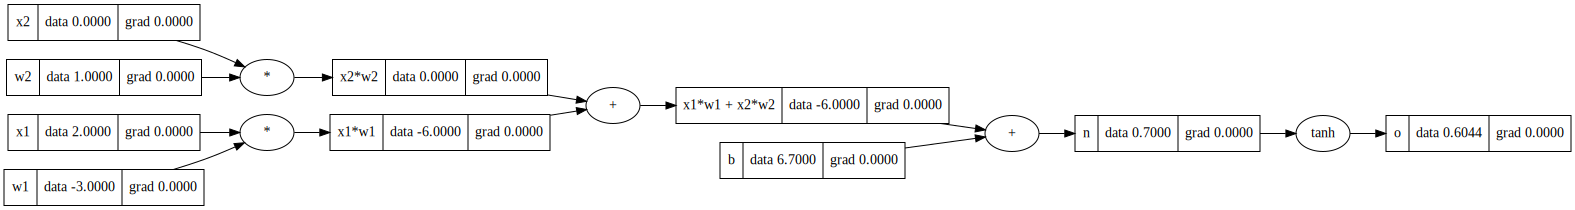

In [66]:
def make_neuron(x_1, w_1, x_2, w_2, b_):
    # inputs x1,x2
    x1 = Value(x_1, label='x1')
    x2 = Value(x_2, label='x2')
    # weights w1, w2
    w1 = Value(w_1, label='w1')
    w2 = Value(w_2, label='w2')
    # Bias of the neuron
    b = Value(b_, label='b')
    # The expression was made in small steps such that we have poiters to them
    x1w1 = x1*w1; x1w1.label='x1*w1'
    x2w2 = x2*w2; x2w2.label='x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh() # Output from the activation function
    return o

n_o = make_neuron(2.0, -3.0, 0.0, 1.0, 6.7); n_o.label = 'o'
draw_dot(n_o)

In [67]:
# Because we initialized the .grad to 0 when initializing at first
o.grad = 1.0 
o._backward()

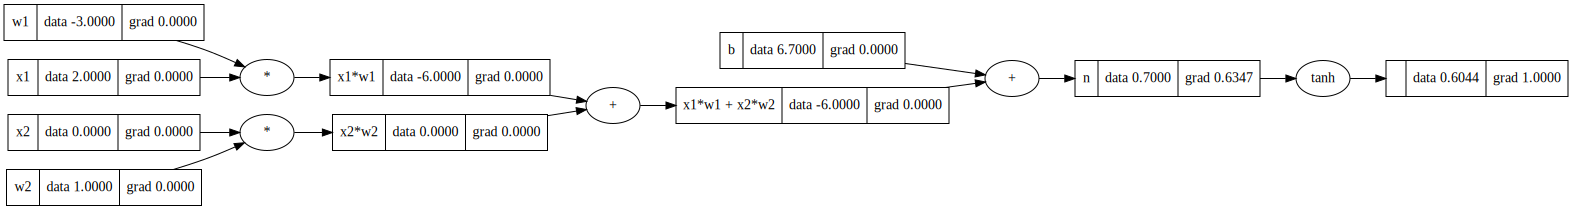

In [68]:
draw_dot(o)

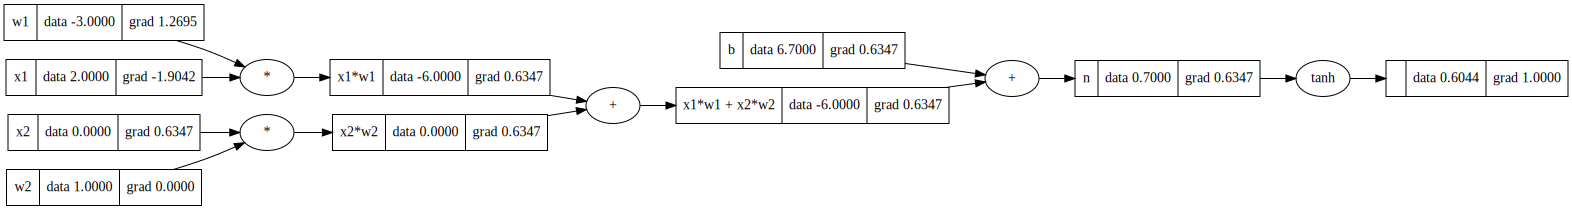

In [69]:
n._backward()
b._backward() # Nothing would happen as it is a leaf node
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

We will be using a topological sort to call backwards on all the nodes (from left to right)

In [70]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.7),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.7000000000000002),
 Value(data=0.6043677771171636)]

In [71]:
# Resetting the gradients
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.881373, label='b')
# The expression was made in small steps such that we have poiters to them
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

In [72]:
# Initializing the final grad
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

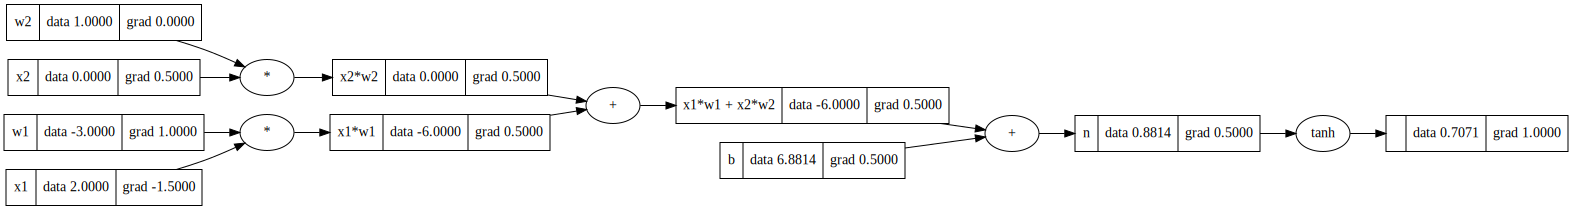

In [73]:
draw_dot(o)

The above code has been added to the value class but was shown here to explain how the backprop works using the topological sort method

In [74]:
# redefining it
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.881373, label='b')
# The expression was made in small steps such that we have poiters to them
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
o.backward()


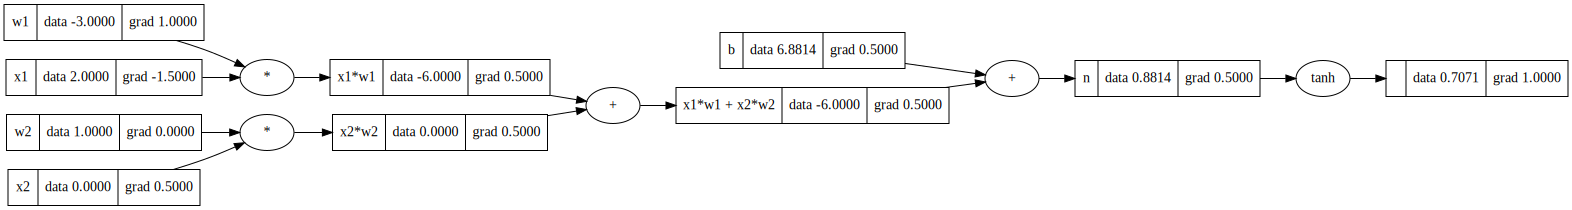

In [75]:
draw_dot(o)

In [76]:
# redefining it with tanh expanded
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.881373, label='b')
# The expression was made in small steps such that we have poiters to them
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----
e = (2*n).exp(); e.label='e'
o = (e - 1) / (e + 1) # Tanh
#-----
o.label='o'
o.backward()

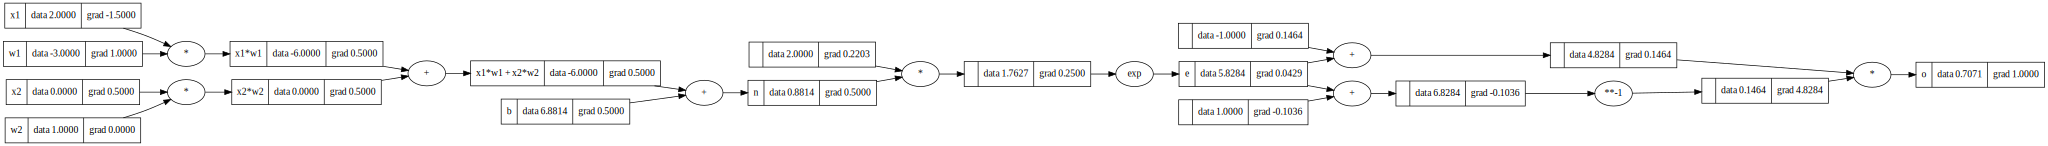

In [77]:
draw_dot(o)

Now, let's try to do the exact same thing but in pytorch api

In [78]:
import torch

x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.tensor([6.8813735]).double()          ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # Tensor have .data and .grad where .item takes
                    # single tensor of that one element (returns this element) while stripping out the tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


So, pytorch agrees with us. Now lets build a neural network and go forward with that

In [137]:
import random
# making a neuron

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x): # help making a forward 
        # w*x + b
        
        # zip takes an iterator and creates a new iterator that iterates over the tuples
        # of the corresponding entries
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        # print(list(zip(self.w, x)))
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
# Making a layer of neurons
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]    
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
# Defining a multi-layer perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [172]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6566871361675611)

In [141]:
len(n.parameters())

41

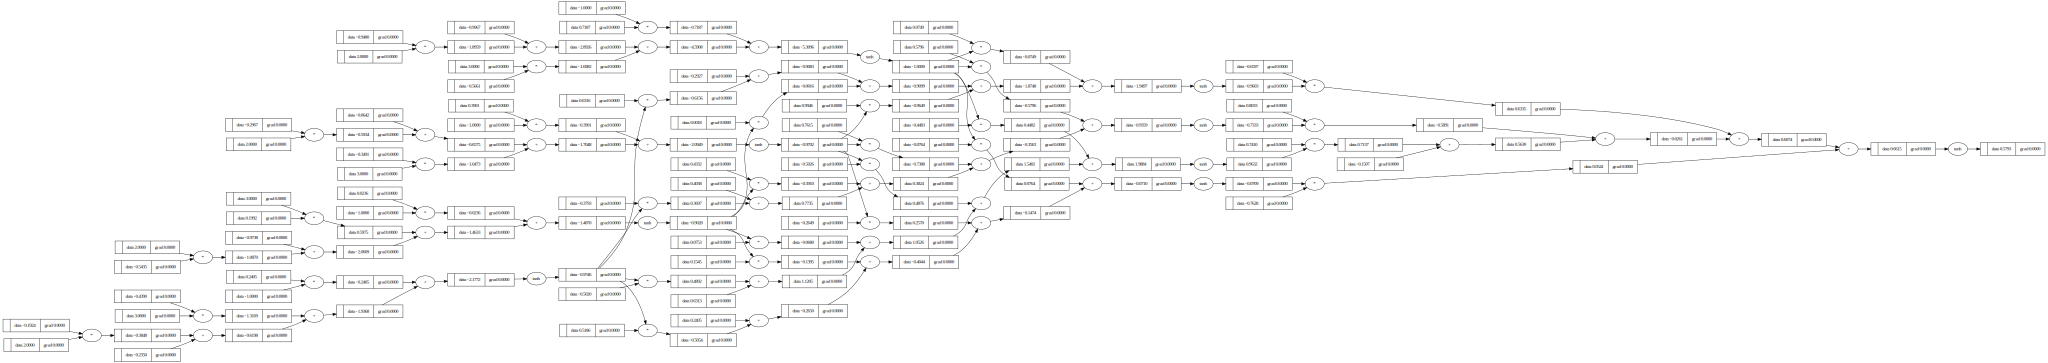

In [135]:
draw_dot(n(x))


In [168]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.1251244633315213),
 Value(data=0.030777037517056266),
 Value(data=-0.46671767749973375),
 Value(data=-0.04087133783559336)]

In [153]:
# Now how do we train it to give the desired output
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]) # Some quantity as a measure of accuracy
loss

Value(data=5.17059219298268)

In [154]:
loss.backward()

In [155]:
n.layers[0].neurons[0].w[1].grad

-0.3693051566865348

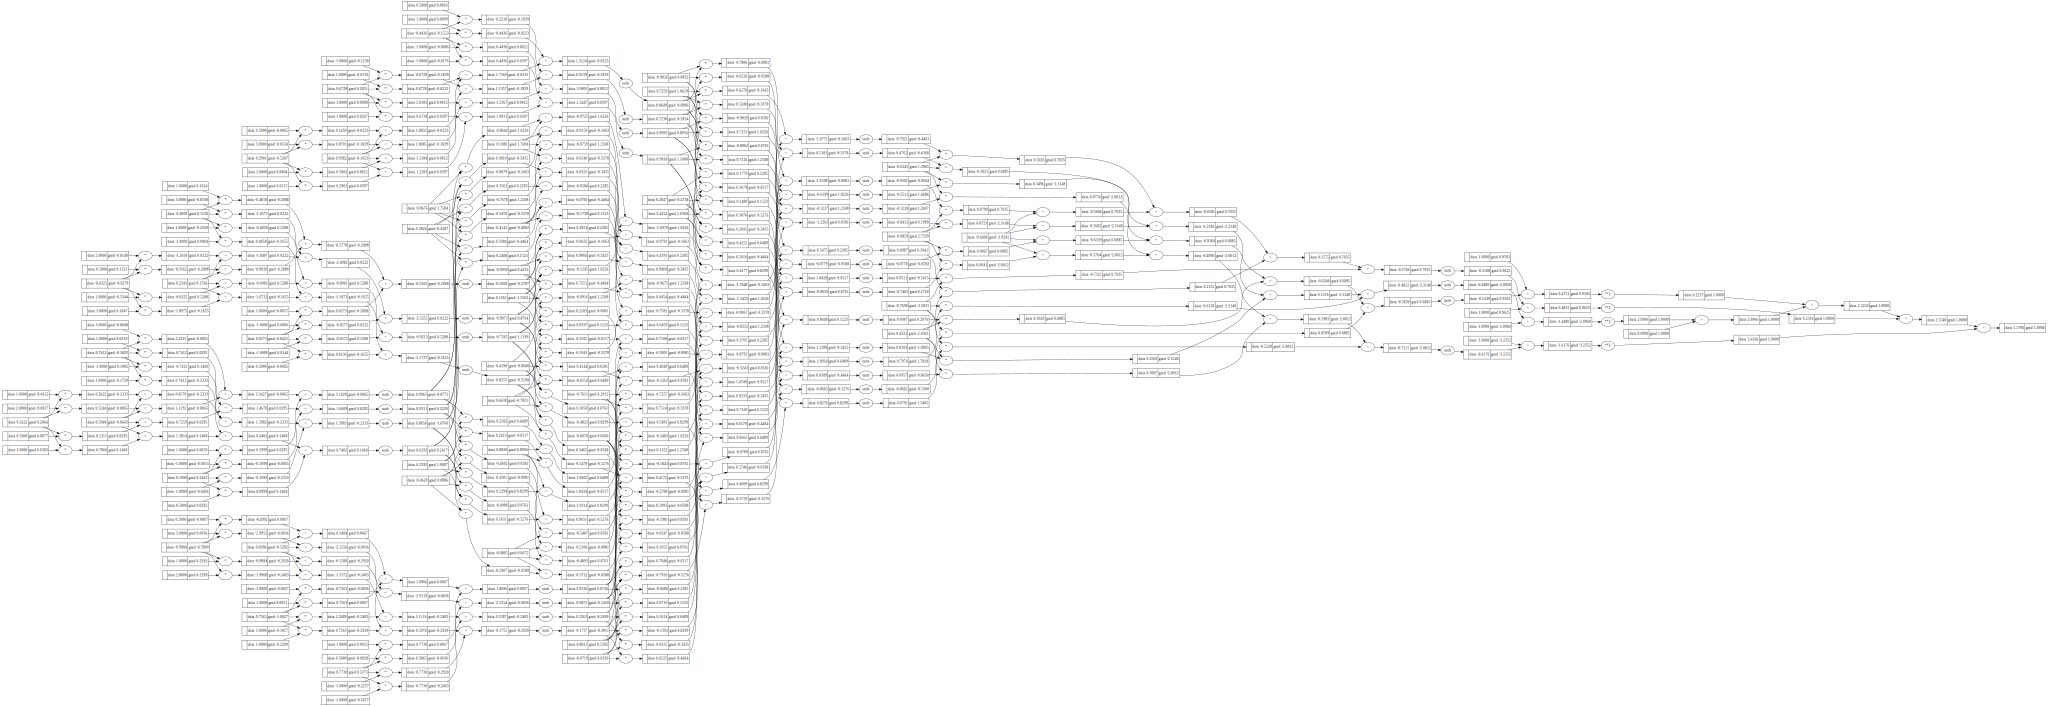

In [156]:
draw_dot(loss)

When we see the graph for loss it is basically the MLP we just created but with another layer of MSE loss on top of it.

Now we have gradients for the leaf nodes as well. But we assume that they stay constant. So, we don't mess with them but we have control over the weights and bias of the perceptron. Which we can tweak to get lower loss

In [159]:
n.layers[0].neurons[0].w[0].data

0.2622030040208858

In [160]:
for p in n.parameters():
    p.data += -0.01 * p.grad # We want to decrease the loss

In [161]:
n.layers[0].neurons[0].w[0].data

0.2601388196972287

Here the tiny nudge is towards the direction that decreases the loss

In [162]:
# Printing the old loss
print(loss)
# Let's re-evaluate the loss
ypred = [n(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
print(loss) # New loss

Value(data=5.17059219298268)
Value(data=4.659861316838892)


As expected there is a decrease in the loss. And our value system and the MLP that we created is improving its prediction

In [174]:
# Iterating over the this step

for k in range(30):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
    
    # Setting all the grads to zero
    for p in n.parameters():
        p.grad = 0.0
    
    #backward pass
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += - 0.05 * p.grad
        
    if k%5 == 0:
        print(f'Loss for the iteration {k} is', loss.data)


Loss for the iteration 0 is 2.063843050395351
Loss for the iteration 5 is 0.3675807997219305
Loss for the iteration 10 is 0.1268327935746159
Loss for the iteration 15 is 0.07005707454011248
Loss for the iteration 20 is 0.04696847869768553
Loss for the iteration 25 is 0.03484519319778971


In [164]:
ypred = [n(x) for x in xs]
[(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=1.8941410831015655e-09),
 Value(data=8.519558522820582e-11),
 Value(data=1.598096685073488e-06),
 Value(data=2.785388334250145e-09)]

As we can see that now the model has trained over the input ground truths :D